In [1]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# MVPC Oracle
from mvpc.mvpc_oracle import MVPC_Oracle

# CI tests
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

# Missingness generation
from data.synthetic_data_generation.missingness_synthetic import (
    create_mar_ind, create_mnar_ind,
    generate_missing_values
)

# DAG utilities
from data.synthetic_data_generation.dag_and_data import (
    detect_colliders, detect_collider_parents
)


In [3]:
# mvpc_vars = [
#     "Sodium", "Potassium", "Chloride", "Creatinine", "Urea Nitrogen",
#     "Hematocrit", "Hemoglobin", "WBC", "Platelet Count", "Glucose",
#     "anchor_age", "length_of_stay_hours",
# ]

# num_var = len(mvpc_vars)
# idx = {v: i for i, v in enumerate(mvpc_vars)}

# adj_true = np.zeros((num_var, num_var))

# # Collider 1
# adj_true[idx["Sodium"], idx["Creatinine"]] = 1
# adj_true[idx["Potassium"], idx["Creatinine"]] = 1

# # Collider 2
# adj_true[idx["Chloride"], idx["Urea Nitrogen"]] = 1
# adj_true[idx["Potassium"], idx["Urea Nitrogen"]] = 1

# # Collider 3
# adj_true[idx["Sodium"], idx["Glucose"]] = 1
# adj_true[idx["Chloride"], idx["Glucose"]] = 1

# # Collider 4
# adj_true[idx["Creatinine"], idx["Hemoglobin"]] = 1
# adj_true[idx["Glucose"], idx["Hemoglobin"]] = 1

# # Collider 5
# adj_true[idx["Glucose"], idx["WBC"]] = 1
# adj_true[idx["Urea Nitrogen"], idx["WBC"]] = 1

# # Collider 6
# adj_true[idx["Hemoglobin"], idx["Platelet Count"]] = 1
# adj_true[idx["Hematocrit"], idx["Platelet Count"]] = 1

# # Collider 7
# adj_true[idx["Hemoglobin"], idx["length_of_stay_hours"]] = 1
# adj_true[idx["WBC"], idx["length_of_stay_hours"]] = 1
# adj_true[idx["anchor_age"], idx["length_of_stay_hours"]] = 1

# adj_true


In [4]:
mvpc_vars = [
    "Sodium", "Potassium", "Chloride", "Creatinine", "Urea Nitrogen",
    "Hematocrit", "Hemoglobin", "WBC", "Platelet Count", "Glucose",
    "anchor_age", "length_of_stay_hours",
]

num_var = len(mvpc_vars)
idx = {v: i for i, v in enumerate(mvpc_vars)}

adj_true = np.zeros((num_var, num_var))

# Keep a few key relations, but fewer colliders

# Collider 1: Creatinine <- Sodium, Potassium
adj_true[idx["Sodium"], idx["Creatinine"]] = 1
adj_true[idx["Potassium"], idx["Creatinine"]] = 1

# Collider 2: Glucose <- Sodium, Chloride
adj_true[idx["Sodium"], idx["Glucose"]] = 1
adj_true[idx["Chloride"], idx["Glucose"]] = 1

# Simple chains instead of many colliders
adj_true[idx["Creatinine"], idx["Urea Nitrogen"]] = 1
adj_true[idx["Urea Nitrogen"], idx["WBC"]] = 1

adj_true[idx["Hemoglobin"], idx["Hematocrit"]] = 1
adj_true[idx["Hemoglobin"], idx["Platelet Count"]] = 1

# LOS with fewer parents: length_of_stay_hours <- WBC, anchor_age
adj_true[idx["WBC"], idx["length_of_stay_hours"]] = 1
adj_true[idx["anchor_age"], idx["length_of_stay_hours"]] = 1

adj_true


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
def gen_linear_gaussian_data(adj, n_samples, seed=42, noise_scale=1.0):
    rng = np.random.default_rng(seed)
    d = adj.shape[0]
    X = np.zeros((n_samples, d))

    # Random weights for edges
    W = adj * rng.normal(loc=0.8, scale=0.3, size=adj.shape)

    # Topological order (0..d-1 works because your DAG is acyclic)
    order = list(range(d))

    for j in order:
        parents = np.where(adj[:, j] == 1)[0]
        if len(parents) == 0:
            X[:, j] = rng.normal(0, noise_scale, size=n_samples)
        else:
            X[:, j] = X[:, parents] @ W[parents, j] + rng.normal(0, noise_scale, size=n_samples)

    return X


In [6]:
def build_prt_m_from_ms(ms, prt_ms):
    prt_dict = {}
    for m, p in zip(ms, prt_ms):
        prt_dict.setdefault(m, []).append(p)
    m_inds = sorted(prt_dict.keys())
    return {"m": m_inds, "prt": prt_dict}


In [7]:
def shd_directed(G_est, G_true):
    return np.sum(G_est != G_true)

def f1_directed(G_est, G_true):
    est = G_est.flatten()
    true = G_true.flatten()

    TP = np.sum((est == 1) & (true == 1))
    FP = np.sum((est == 1) & (true == 0))
    FN = np.sum((est == 0) & (true == 1))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall    = TP / (TP + FN) if TP + FN > 0 else 0
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


In [8]:
sample_sizes = [500, 1000, 2000, 5000, 10000]
n_reps = 50

num_extra_e = 3
num_m = 6

p_missing_h = 0.9
p_missing_l = 0.1

modes = ["MAR", "MNAR"]
methods = ["td", "permc", "drw"]

all_results = []


In [9]:
def record_result(results_list, mode, method, n, shd, f1):
    results_list.append({
        "mode": mode,
        "method": method,
        "n": n,
        "shd": shd,
        "f1": f1,
    })


In [10]:
for n in sample_sizes:
    for rep in range(n_reps):

        # 1. Generate synthetic data
        X_complete = gen_linear_gaussian_data(adj_true, n_samples=n, seed=rep)

        # 2. Detect colliders
        colliders = detect_colliders(adj_true)
        collider_parents = detect_collider_parents(adj_true, colliders)

        # 3. Generate missingness structures
        ms_mar, prt_ms_mar = create_mar_ind(
            colliders, collider_parents, num_var,
            num_extra_e=num_extra_e, num_m=num_m, seed=rep
        )
        ms_mnar, prt_ms_mnar = create_mnar_ind(
            colliders, collider_parents, num_var,
            num_extra_e=num_extra_e, num_m=num_m, seed=rep
        )

        # 4. Oracle prt_m
        prt_m_mar  = build_prt_m_from_ms(ms_mar,  prt_ms_mar)
        prt_m_mnar = build_prt_m_from_ms(ms_mnar, prt_ms_mnar)

        # 5. Generate missing data
        X_mar = generate_missing_values(
            X_complete, ms_mar, prt_ms_mar,
            p_missing_h=p_missing_h, p_missing_l=p_missing_l, seed=rep
        )
        X_mnar = generate_missing_values(
            X_complete, ms_mnar, prt_ms_mnar,
            p_missing_h=p_missing_h, p_missing_l=p_missing_l, seed=rep
        )

        # 6. Run MVPC Oracle
        for mode, X_m, prt_m in [
            ("MAR",  X_mar,  prt_m_mar),
            ("MNAR", X_mnar, prt_m_mnar),
        ]:

            for method in methods:
                if method == "td":
                    mvpc = MVPC_Oracle(gauss_ci_td, gauss_ci_td)
                elif method == "permc":
                    mvpc = MVPC_Oracle(gauss_ci_td, gauss_ci_permc)
                elif method == "drw":
                    mvpc = MVPC_Oracle(gauss_ci_td, gauss_ci_drw)

                G = mvpc.run(X_m, prt_m)["G_corrected"]

                shd = shd_directed(G, adj_true)
                f1  = f1_directed(G, adj_true)

                record_result(all_results, mode, method, n, shd, f1)


Corrected skeleton, ord=0:   0%|          | 0/24 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(all_results)

summary = (
    df.groupby(["mode", "method", "n"])
      .agg(mean_shd=("shd", "mean"),
           mean_f1=("f1", "mean"))
      .reset_index()
)

summary


,mode,method,n,mean_shd,mean_f1
0,MAR,drw,500,12.16,0.587211
1,MAR,drw,1000,12.60,0.585012
2,MAR,drw,2000,12.72,0.585511
3,MAR,drw,5000,12.32,0.593183
4,MAR,drw,10000,12.72,0.588153
5,MAR,permc,500,11.96,0.591688
6,MAR,permc,1000,12.12,0.595349
7,MAR,permc,2000,12.04,0.600222
8,MAR,permc,5000,11.44,0.611865
9,MAR,permc,10000,11.64,0.609943


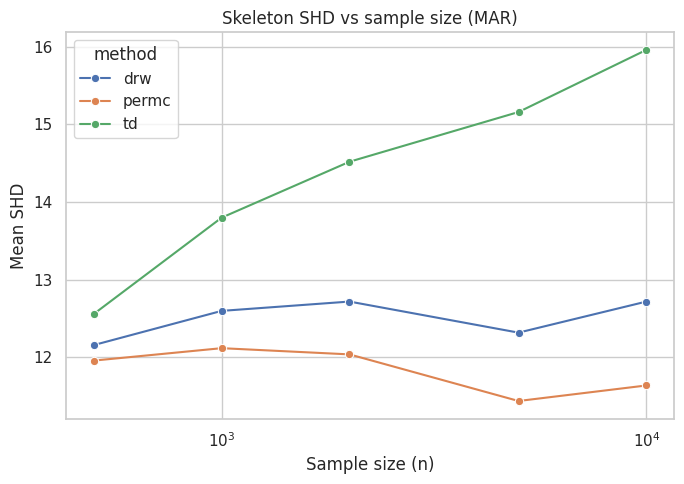

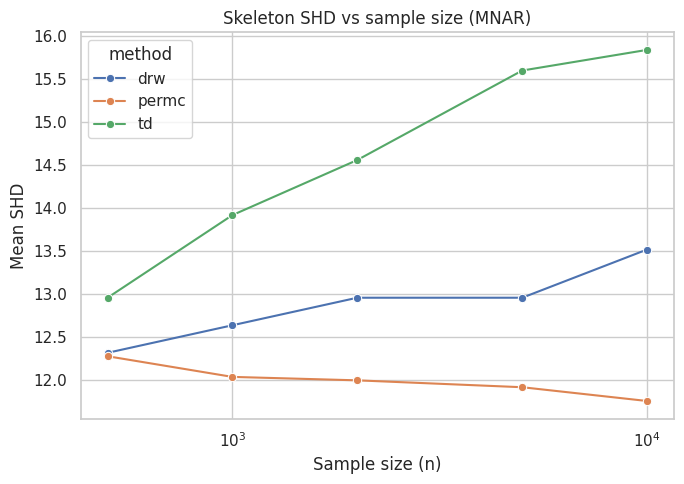

In [12]:
for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary[summary["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_shd",
        hue="method",
        marker="o"
    )

    plt.title(f"Skeleton SHD vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean SHD")
    plt.xscale("log")
    plt.tight_layout()
    plt.show()


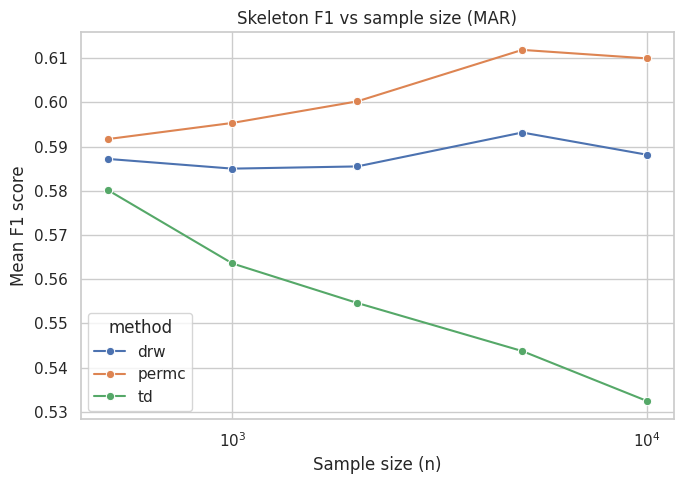

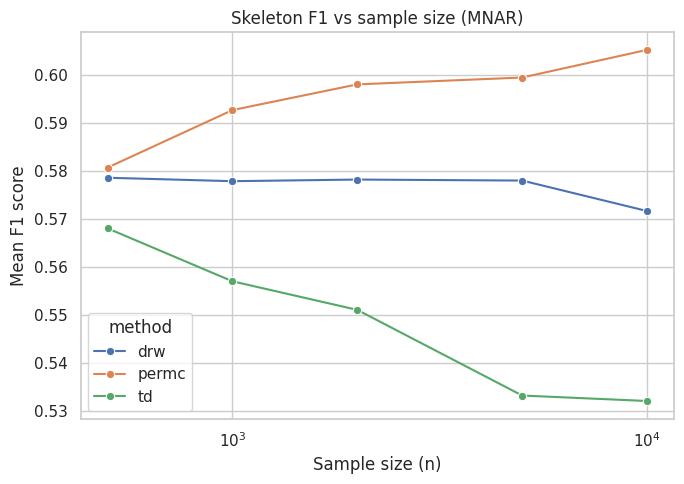

In [13]:
for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary[summary["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_f1",
        hue="method",
        marker="o"
    )

    plt.title(f"Skeleton F1 vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean F1 score")
    plt.xscale("log")
    plt.tight_layout()
    plt.show()
